# Soccer Match Outcome Predictor

The following code will build a soccer match outcome prediction model using nural networks with team embeddings and match history embeddings.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Dense, Concatenate, Dropout, Flatten, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from keras import layers, models, optimizers, callbacks
import keras_tuner as kt

## Preprocessing the Dataset


Loading the Dataset

In [2]:
df = pd.read_csv('matches_expanded.csv')
df.head(10)

,match_id,home_team,away_team,home_goals,away_goals,match_outcome,Home_Ball_Possession,Home_Pass_Accuracy,Home_Total_Shots,Home_Expected_Goals,Away_Ball_Possession,Away_Pass_Accuracy,Away_Total_Shots,Away_Expected_Goals
0,1035037,Burnley,Manchester City,0,3,Loss,34%,79%,6.0,0.33,66%,90%,17.0,2.08
1,1035038,Arsenal,Nottingham Forest,2,1,Win,78%,90%,15.0,0.83,22%,69%,6.0,1.18
2,1035039,Bournemouth,West Ham,1,1,Draw,63%,82%,14.0,1.37,37%,68%,16.0,1.07
3,1035041,Everton,Fulham,0,1,Loss,41%,79%,19.0,2.73,59%,85%,9.0,1.50
4,1035040,Brighton,Luton,4,1,Win,71%,91%,27.0,4.01,29%,72%,9.0,1.48
5,1035042,Sheffield Utd,Crystal Palace,0,1,Loss,32%,62%,8.0,0.51,68%,83%,24.0,1.89
6,1035043,Newcastle,Aston Villa,5,1,Win,53%,85%,17.0,3.41,47%,85%,16.0,1.77
7,1035044,Brentford,Tottenham,2,2,Draw,30%,77%,11.0,2.22,70%,90%,18.0,1.27
8,1035045,Chelsea,Liverpool,1,1,Draw,65%,87%,10.0,1.35,35%,80%,13.0,1.28
9,1035046,Manchester United,Wolves,1,0,Win,51%,82%,15.0,2.21,49%,81%,23.0,2.35


Cleaning the Dataframe

In [3]:
df.columns = df.columns.str.lower()

df['home_ball_possession'] = df['home_ball_possession'].str.replace('%', '', regex=True).astype(float)
df['home_pass_accuracy'] = df['home_pass_accuracy'].str.replace('%', '', regex=True).astype(float)
df['away_ball_possession'] = df['away_ball_possession'].str.replace('%', '', regex=True).astype(float)
df['away_pass_accuracy'] = df['away_pass_accuracy'].str.replace('%', '', regex=True).astype(float)


df.head(10)

,match_id,home_team,away_team,home_goals,away_goals,match_outcome,home_ball_possession,home_pass_accuracy,home_total_shots,home_expected_goals,away_ball_possession,away_pass_accuracy,away_total_shots,away_expected_goals
0,1035037,Burnley,Manchester City,0,3,Loss,34.0,79.0,6.0,0.33,66.0,90.0,17.0,2.08
1,1035038,Arsenal,Nottingham Forest,2,1,Win,78.0,90.0,15.0,0.83,22.0,69.0,6.0,1.18
2,1035039,Bournemouth,West Ham,1,1,Draw,63.0,82.0,14.0,1.37,37.0,68.0,16.0,1.07
3,1035041,Everton,Fulham,0,1,Loss,41.0,79.0,19.0,2.73,59.0,85.0,9.0,1.50
4,1035040,Brighton,Luton,4,1,Win,71.0,91.0,27.0,4.01,29.0,72.0,9.0,1.48
5,1035042,Sheffield Utd,Crystal Palace,0,1,Loss,32.0,62.0,8.0,0.51,68.0,83.0,24.0,1.89
6,1035043,Newcastle,Aston Villa,5,1,Win,53.0,85.0,17.0,3.41,47.0,85.0,16.0,1.77
7,1035044,Brentford,Tottenham,2,2,Draw,30.0,77.0,11.0,2.22,70.0,90.0,18.0,1.27
8,1035045,Chelsea,Liverpool,1,1,Draw,65.0,87.0,10.0,1.35,35.0,80.0,13.0,1.28
9,1035046,Manchester United,Wolves,1,0,Win,51.0,82.0,15.0,2.21,49.0,81.0,23.0,2.35


Converting Team Names to Integer IDs

In [4]:
team_encoder = LabelEncoder()
df['home_team_id'] = team_encoder.fit_transform(df['home_team'])
df['away_team_id'] = team_encoder.transform(df['away_team'])
df.head(10)

,match_id,home_team,away_team,home_goals,away_goals,match_outcome,home_ball_possession,home_pass_accuracy,home_total_shots,home_expected_goals,away_ball_possession,away_pass_accuracy,away_total_shots,away_expected_goals,home_team_id,away_team_id
0,1035037,Burnley,Manchester City,0,3,Loss,34.0,79.0,6.0,0.33,66.0,90.0,17.0,2.08,5,12
1,1035038,Arsenal,Nottingham Forest,2,1,Win,78.0,90.0,15.0,0.83,22.0,69.0,6.0,1.18,0,15
2,1035039,Bournemouth,West Ham,1,1,Draw,63.0,82.0,14.0,1.37,37.0,68.0,16.0,1.07,2,18
3,1035041,Everton,Fulham,0,1,Loss,41.0,79.0,19.0,2.73,59.0,85.0,9.0,1.50,8,9
4,1035040,Brighton,Luton,4,1,Win,71.0,91.0,27.0,4.01,29.0,72.0,9.0,1.48,4,11
5,1035042,Sheffield Utd,Crystal Palace,0,1,Loss,32.0,62.0,8.0,0.51,68.0,83.0,24.0,1.89,16,7
6,1035043,Newcastle,Aston Villa,5,1,Win,53.0,85.0,17.0,3.41,47.0,85.0,16.0,1.77,14,1
7,1035044,Brentford,Tottenham,2,2,Draw,30.0,77.0,11.0,2.22,70.0,90.0,18.0,1.27,3,17
8,1035045,Chelsea,Liverpool,1,1,Draw,65.0,87.0,10.0,1.35,35.0,80.0,13.0,1.28,6,10
9,1035046,Manchester United,Wolves,1,0,Win,51.0,82.0,15.0,2.21,49.0,81.0,23.0,2.35,13,19


Generating Historical Performace Features



In [5]:
N = 5  # Number of past matches to consider

def get_past_stats(df, team_col, stat_col, N):
    """
    Computes rolling average for the last N matches per team.
    If rolling value is NaN (not enough history), fill it with the current match's stat.
    """
    rolling_avg = df.groupby(team_col)[stat_col].transform(lambda x: x.shift(1).rolling(N, min_periods=1).mean())
    
    # Fill NaNs with the current match stat as a fallback
    rolling_avg = rolling_avg.fillna(df[stat_col])
    
    return rolling_avg

historical_features = ["goals", "ball_possession", "pass_accuracy", "total_shots", "expected_goals"]

for feature in historical_features:
    home_feature_col = f'home_{feature}'
    away_feature_col = f'away_{feature}'

    df[f'{home_feature_col}_hist'] = get_past_stats(df, 'home_team', home_feature_col, N=5)
    df[f'{away_feature_col}_hist'] = get_past_stats(df, 'away_team', away_feature_col, N=5)


df.head(10)
df.to_csv('cleaned_matches_expanded.csv', index=False)

Standard Scaling

In [6]:
numerical_cols = [col for col in df.columns if '_hist' in col or col in [
    'home_ball_possession', 'home_pass_accuracy', 'home_total_shots', 'home_expected_goals'
    'away_ball_possession', 'away_pass_accuracy', 'away_total_shots', 'away_expected_goals'
]]

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

Label Encode Target (Win/Draw/Loss)

In [8]:
# Assuming perspective is home team
# Win = 2, Draw = 0, Loss = 1

outcome_encoder = LabelEncoder()
df['outcome_encoded'] = outcome_encoder.fit_transform(df['match_outcome'])
y = to_categorical(df['outcome_encoded'], num_classes=3)

df.head(10)

,match_id,home_team,away_team,home_goals,away_goals,match_outcome,home_ball_possession,home_pass_accuracy,home_total_shots,home_expected_goals,away_ball_possession,away_pass_accuracy,away_total_shots,away_expected_goals,home_team_id,away_team_id,home_goals_hist,away_goals_hist,home_ball_possession_hist,away_ball_possession_hist,home_pass_accuracy_hist,away_pass_accuracy_hist,home_total_shots_hist,away_total_shots_hist,home_expected_goals_hist,away_expected_goals_hist,outcome_encoded
0,1035037,Burnley,Manchester City,0,3,Loss,-1.259454,-0.335618,-1.499365,0.33,66.0,1.266420,0.878965,0.877932,5,12,-2.064366,2.215913,-1.707908,1.590768,-0.403914,1.564515,-2.269026,1.250858,-2.259556,1.362230,1
1,1035038,Arsenal,Nottingham Forest,2,1,Win,1.873255,1.134908,-0.067011,0.83,22.0,-1.484270,-1.128726,-0.233210,0,15,0.280862,-0.635020,2.511828,-2.365174,1.381230,-1.805179,-0.037465,-1.761608,-1.470070,-0.440598,2
2,1035039,Bournemouth,West Ham,1,1,Draw,0.805286,0.065435,-0.226161,1.37,37.0,-1.615255,0.696448,-0.369016,2,18,-0.891752,-0.635020,1.073282,-1.016557,0.082944,-1.965640,-0.285416,0.976998,-0.617425,-0.660944,0
3,1035041,Everton,Fulham,0,1,Loss,-0.761068,-0.335618,0.569591,2.73,59.0,0.611494,-0.581174,0.161863,8,9,-2.064366,-0.635020,-1.036586,0.961414,-0.403914,0.762207,0.954340,-0.940026,1.529977,0.200407,1
4,1035040,Brighton,Luton,4,1,Win,1.374869,1.268592,1.842796,4.01,29.0,-1.091314,-0.581174,0.137171,4,11,2.626089,-0.635020,1.840506,-1.735819,1.543516,-1.323794,2.937951,-0.940026,3.551061,0.160344,2
5,1035042,Sheffield Utd,Crystal Palace,0,1,Loss,-1.401849,-2.608248,-1.181064,0.51,68.0,0.349524,2.156586,0.643357,16,7,-2.064366,-0.635020,-1.899714,1.770584,-3.162771,0.441283,-1.773123,3.167882,-1.975341,0.981633,1
6,1035043,Newcastle,Aston Villa,5,1,Win,0.093307,0.466487,0.251290,3.41,47.0,0.611494,0.696448,0.495205,14,1,3.798702,-0.635020,0.114251,-0.117479,0.569801,0.762207,0.458438,0.976998,2.603678,0.741256,2
7,1035044,Brentford,Tottenham,2,2,Draw,-1.544245,-0.602986,-0.703613,2.22,70.0,1.266420,1.061482,-0.122096,3,17,0.280862,0.790446,-2.091520,1.950399,-0.728485,1.564515,-1.029270,1.524719,0.724701,-0.260315,0
8,1035045,Chelsea,Liverpool,1,1,Draw,0.947682,0.733856,-0.862763,1.35,35.0,-0.043432,0.148896,-0.109750,6,10,-0.891752,-0.635020,1.265088,-1.196373,0.894372,-0.040101,-1.277221,0.155416,-0.649005,-0.240284,0
9,1035046,Manchester United,Wolves,1,0,Win,-0.049089,0.065435,-0.067011,2.21,49.0,0.087553,1.974069,1.211274,13,19,-0.891752,-2.060487,-0.077555,0.062336,0.082944,0.120360,-0.037465,2.894022,0.708911,1.903078,2


## Building the Neural Network Model


Spliting Data into Training and Test Datasets

In [9]:
X = df[numerical_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Building the Model

In [10]:
input_layer = Input(shape=(X_train.shape[1],))
x = Dense(128, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(3, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


Training the Model

In [11]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 315ms/step - accuracy: 0.4764 - loss: 1.0842 - val_accuracy: 0.4839 - val_loss: 1.1027
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4773 - loss: 1.0293 - val_accuracy: 0.4839 - val_loss: 1.0854
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.5642 - loss: 0.9896 - val_accuracy: 0.4516 - val_loss: 1.0886
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5760 - loss: 0.9571 - val_accuracy: 0.4516 - val_loss: 1.0743
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6087 - loss: 0.9288 - val_accuracy: 0.4516 - val_loss: 1.0622
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6280 - loss: 0.8763 - val_accuracy: 0.4194 - val_loss: 1.0512
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5931 - loss: 0.9324 - val_accuracy: 0.4194 - val_loss: 1.0381
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6324 - loss: 0.8934 - val_accuracy: 0.4194 - val_loss: 1.04

## Evaluating the Model


Predict and Evalutate

In [12]:
# Predict probabilities on the test set
y_test_probs = model.predict(X_test)

# Predicted class labels (Win, Draw, Loss)
y_test_pred = np.argmax(y_test_probs, axis=1)

# True class labels (converted back from one-hot encoding)
y_test_true = np.argmax(y_test, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step


In [13]:
print("Accuracy:", accuracy_score(y_test_true, y_test_pred))
print("Classification Report:\n", classification_report(y_test_true, y_test_pred, target_names=outcome_encoder.classes_))


Accuracy: 0.5394736842105263
Classification Report:
               precision    recall  f1-score   support

        Draw       0.10      0.07      0.08        14
        Loss       0.55      0.43      0.48        28
         Win       0.64      0.82      0.72        34

    accuracy                           0.54        76
   macro avg       0.43      0.44      0.43        76
weighted avg       0.50      0.54      0.51        76



In [14]:
y_test_pred_labels = outcome_encoder.inverse_transform(y_test_pred)
y_test_true_labels = outcome_encoder.inverse_transform(y_test_true)
# Build a dataframe to compare actual vs predicted
test_results_df = pd.DataFrame({
    'Actual Outcome': y_test_true_labels,
    'Predicted Outcome': y_test_pred_labels,
    'Confidence': np.max(y_test_probs, axis=1),
    'Win Prob': y_test_probs[:, outcome_encoder.transform(['Win'])[0]],
    'Draw Prob': y_test_probs[:, outcome_encoder.transform(['Draw'])[0]],
    'Loss Prob': y_test_probs[:, outcome_encoder.transform(['Loss'])[0]]
})

# Add 'Correct' column (True if prediction matches actual)
test_results_df['Correct'] = (test_results_df['Actual Outcome'] == test_results_df['Predicted Outcome'])

# Show the first few predictions
print(test_results_df.head())
test_results_df.to_csv('test_results_1.csv', index=False)


  Actual Outcome Predicted Outcome  Confidence  ...  Draw Prob  Loss Prob  Correct
0           Loss              Draw    0.627800  ...   0.627800   0.155576    False
1           Loss               Win    0.419511  ...   0.330004   0.250485    False
2            Win               Win    0.686931  ...   0.193458   0.119611     True
3           Draw              Loss    0.605668  ...   0.198962   0.605668    False
4            Win               Win    0.677946  ...   0.189611   0.132443     True

[5 rows x 7 columns]


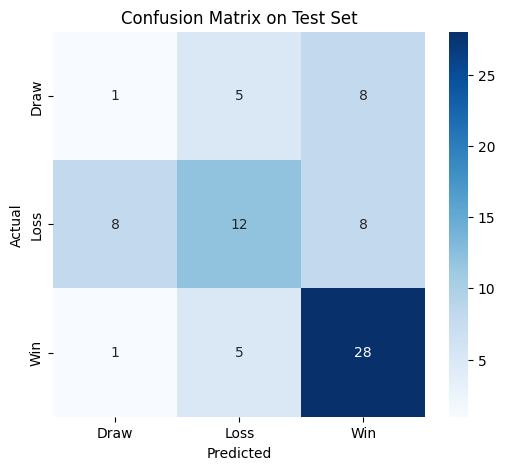

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_test_true_labels, y_test_pred_labels, labels=outcome_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=outcome_encoder.classes_,
            yticklabels=outcome_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

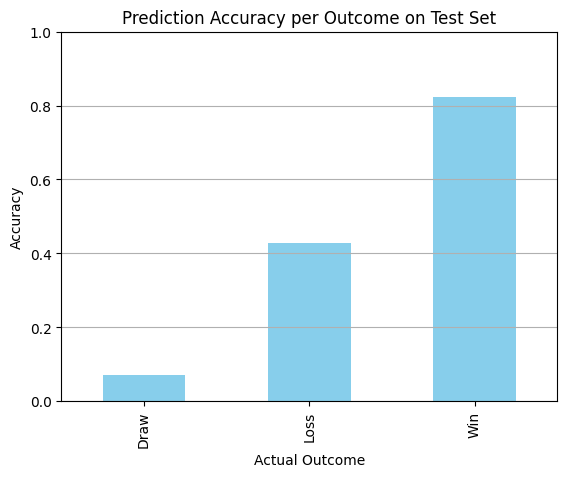

In [16]:
# Group by Actual Outcome and calculate mean accuracy
outcome_accuracy = test_results_df.groupby('Actual Outcome')['Correct'].mean()

# Plot
outcome_accuracy.plot(kind='bar', color='skyblue')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy per Outcome on Test Set')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


In [17]:
# Define low confidence threshold
low_confidence_threshold = 0.6

# Create a column marking low-confidence wrong predictions
test_results_df['Low-Confidence Wrong'] = (
    (~test_results_df['Correct']) & (test_results_df['Confidence'] < low_confidence_threshold)
)

# Display only low-confidence wrong predictions
low_conf_wrong_preds = test_results_df[test_results_df['Low-Confidence Wrong']]

print(f"Low-Confidence Wrong Predictions: {len(low_conf_wrong_preds)} matches")
print(low_conf_wrong_preds[['Actual Outcome', 'Predicted Outcome', 'Confidence']])


Low-Confidence Wrong Predictions: 19 matches
   Actual Outcome Predicted Outcome  Confidence
1            Loss               Win    0.419511
10           Draw              Loss    0.468959
12            Win              Draw    0.420370
14           Draw               Win    0.362205
19           Loss              Draw    0.461315
20           Loss              Draw    0.514720
21           Loss              Draw    0.367622
23            Win              Loss    0.575192
31           Loss              Draw    0.472523
37            Win              Loss    0.502456
39            Win              Loss    0.375914
40           Loss              Draw    0.558619
41           Loss              Draw    0.504994
47           Loss              Draw    0.443911
54           Draw              Loss    0.470158
56           Loss               Win    0.432455
62           Draw               Win    0.442954
65            Win              Loss    0.528060
75           Loss               Win    0.50

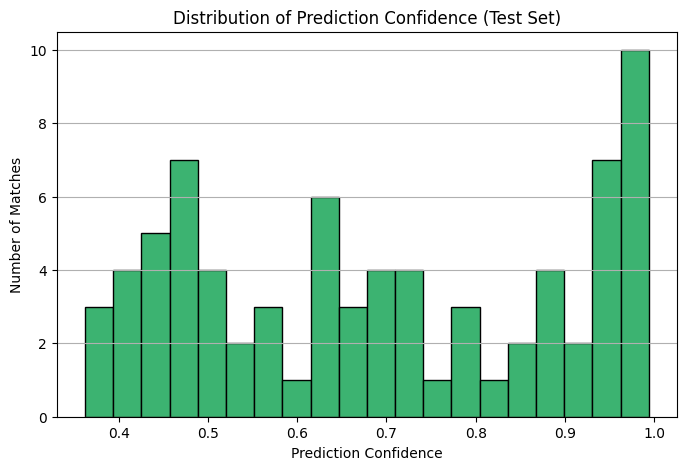

In [18]:
# Plot the distribution of confidence scores
plt.figure(figsize=(8,5))
plt.hist(test_results_df['Confidence'], bins=20, color='mediumseagreen', edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Number of Matches')
plt.title('Distribution of Prediction Confidence (Test Set)')
plt.grid(axis='y')
plt.show()

## Hyperparameter Tuning

Defining a Hypermodel

In [19]:
from keras import layers, models, optimizers
import keras_tuner as kt

def build_model(hp):
    model = models.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(X_train.shape[1],)))
    
    # Tune number of hidden layers (1–3)
    for i in range(hp.Int('num_layers', 1, 3)):
        # Tune units per layer
        units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)
        model.add(layers.Dense(units, activation='relu'))
        
        # Tune dropout rate
        dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)
        model.add(layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(layers.Dense(3, activation='softmax'))  # 3 classes (Win, Draw, Loss)
    
    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


Hyperparameter Search

In [20]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # How many different models to try
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_dir',
    project_name='soccer_match_outcome'
)

# Perform the search
tuner.search(
    X_train, y_train,
    epochs=30,
    validation_split=0.2,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 20 Complete [00h 00m 25s]
val_accuracy: 0.5901639461517334

Best val_accuracy So Far: 0.5901639461517334
Total elapsed time: 00h 06m 51s


Validation Accuracy Across Trials

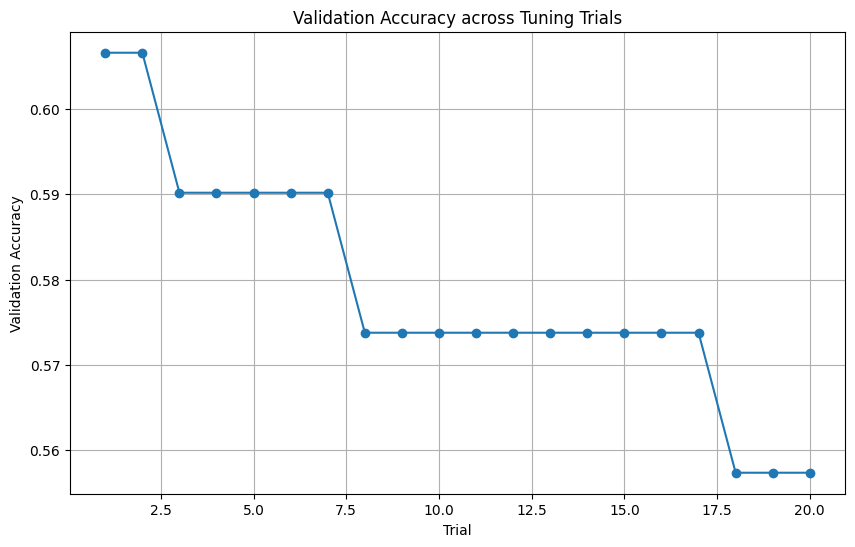

In [32]:
# Get all the tuning results
tuner_results = tuner.oracle.get_best_trials(num_trials=20)

# Extract val_accuracy from each trial
val_accuracies = [trial.metrics.get_last_value('val_accuracy') for trial in tuner_results]

plt.figure(figsize=(10,6))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, marker='o', linestyle='-')
plt.xlabel('Trial')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy across Tuning Trials')
plt.grid(True)
plt.show()


There was no better model found using random search. We are going to use Bayesian optimization as well as smarter search ranges, better validation, and early stopping to hopefully find a better model

Defining a new hypermodel

In [25]:
def build_model(hp):
    model = models.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(X_train.shape[1],)))  # Adjust if you have team embeddings added

    # Hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(
            layers.Dense(
                units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=32),
                activation='relu'
            )
        )
        model.add(
            layers.Dropout(
                rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)
            )
        )

    # Output layer
    model.add(layers.Dense(3, activation='softmax'))

    # Optimizer
    optimizer = optimizers.Adam(
        learning_rate=hp.Float('learning_rate', 1e-4, 5e-3, sampling='log')
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

Hyperparameter Seach

In [34]:
# 2. Instantiate Bayesian tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=100,           # More trials = better search, you can adjust
    executions_per_trial=1,  # Averaging can be added if you want even smoother results
    directory='tuner_dir',
    project_name='soccer_outcome_bayes'
)

# 3. Early stopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 4. Launch the tuning search
tuner.search(
    X_train, y_train,
    epochs=50,                     # Train longer so tuner sees real model potential
    validation_split=0.2,           # 20% validation
    callbacks=[early_stopping],
    verbose=2
)

# 5. Retrieve the best model
best_hp = tuner.get_best_hyperparameters(1)[0]

Trial 100 Complete [00h 00m 10s]
val_accuracy: 0.5409836173057556

Best val_accuracy So Far: 0.6229507923126221
Total elapsed time: 02h 17m 13s


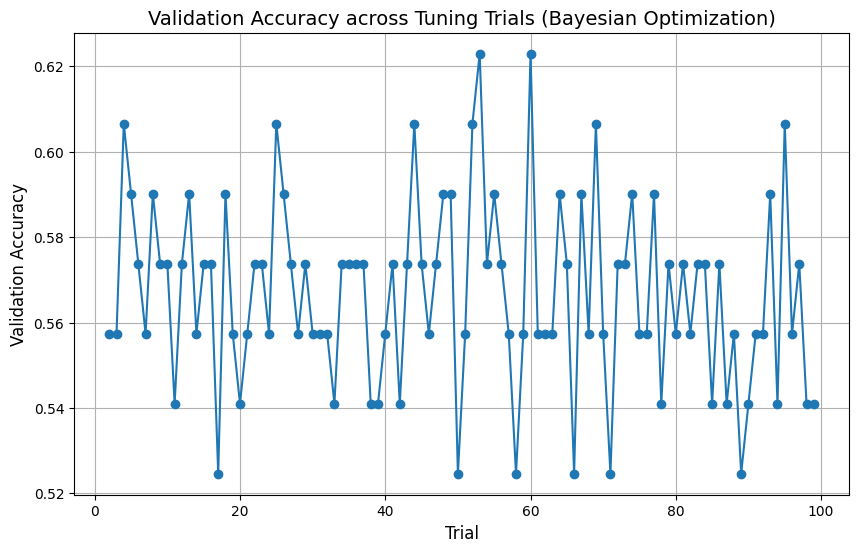

In [ ]:
# Get all trials
trials = tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials))

# Extract validation metrics
trial_scores = []
for trial in trials:
    trial_id = trial.trial_id
    metrics_names = trial.metrics.metrics.keys()  # List available metrics

    if 'val_accuracy' in metrics_names:
        val_score = trial.metrics.get_last_value('val_accuracy')
        metric_used = 'Validation Accuracy'
    elif 'val_loss' in metrics_names:
        val_score = -trial.metrics.get_last_value('val_loss')  # Negative because lower loss = better
        metric_used = 'Negative Validation Loss'
    else:
        val_score = None  # Shouldn't happen unless tuning broke
        metric_used = 'Unknown'
    
    trial_scores.append((int(trial_id), val_score, metric_used))

# Build DataFrame
trials_df = pd.DataFrame(trial_scores, columns=['Trial', 'Score', 'Metric'])

# Sort by trial number
trials_df = trials_df.sort_values('Trial')

# Plot
plt.figure(figsize=(10,6))
plt.plot(trials_df['Trial'], trials_df['Score'], marker='o')
plt.title('Validation Accuracy across Tuning Trials (Bayesian Optimization)', fontsize=14)
plt.xlabel('Trial', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.grid(True)
plt.show()

